# Customer Lifetime Value (CLTV)  用戶生命週期價值計算及消費預測
> 利用機器學習，透過消費者的消費記錄來計算消費者Lifetime Value，並推估該用戶未來六個月的消費數據.

> 延伸閱讀：透過 kmeans 進行消費族群分群

- toc: true 
- badges: true
- comments: false
- sticky_rank: 1
- author: ChiHong Lin 
- categories: [python, prediction, jupyter, customer life time value, sales]


## Customer Lifetime Value (CLTV or CLV) 是什麼

顧名思義，Customer Lifetime Value就是用戶在其生命週期內所能帶來的商業價值。以商業市場來說，CLTV 即是消費者從第一次購買你的產品，直到不再購買你的產品為止，在這段時間內對於你的公司所貢獻的商業價值。

### 為什麼需要 CLTV 作為衡量指標

#### 輔助制定 CAC 指標

CAC (Customer Acquisition Cost) 代表獲取一個顧客的成本，在商業經營中，唯有用戶在其生命週期內所帶來的商業價值（CLTV） 大於 獲取這位顧客的成本(CAC)，這個 Business 才能持續地滾動下去。因此，透過CLTV，商業經營者可以更加明確的規劃面相於故各地個性行銷活動，以確保商業模式能夠長久運轉。

#### 可持續性的增長指標

隨著技術對用戶的生活產生改變，用戶的接觸點（Endpoints）越來越多多樣化，相對應的行銷策略與手段也因此而產生了重大變化，新零售（OMO）概念正充分說明，光是倚靠 Revenue 或是 CAC 來作為指標，無法有效的去衡量日常所做的每個項目投入；若是持續的僅使用這兩個指標來做衡量，甚至可能因此讓錯失了很多重要的項目無法被實施。

CLTV 和傳統常見的指標最大的不同在於：是將多個部門的「心血」所匯集在一起呈現的指標。
CLTV的增長，反映了行銷、產品、業務跨三個部門協同運作的成果，將單一部門的活動轉化成了整體的經營成效增長。

>CLTV一直是 Amazon 內部採用作為日常增長指標來判斷一個項目/業務是否成功的衡量方式，像是知名的 Kindle 業務即是在這樣的文化下所誕生並且成功。以一個近乎成本價的方式銷售 Kindle device，而購買 Kindle 後的用戶其設備上產生的消費金額，才是衡量該業務成功與否的核心指標。

在這個實作中，我將以消費紀錄為基礎，利用機器學習，來計算消費者 Lifetime Value，並推估該用戶未來六個月的消費數據。

**數據資料**

在本次使用的消費紀錄資料中，包含了以下欄位：

* *消費日期*
* *Invoice Number*
* *客戶編號*
* *消費金額*

首先，我們導入此次專案所需要的 Python 函式庫

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

接下來，進行數據資料的讀取及匯入

In [2]:
# Loading the data
#data = pd.read_csv("datasource/data.csv",  parse_dates=['invoice_date'])
data_clv = pd.read_csv("datasource/CLTV_data.csv",  parse_dates=['invoice_date'])
print("Total number of transactions happened in the given period: "+ str(data_clv.shape[0]))
data_clv.head(5)

Total number of transactions happened in the given period: 32030


,invoice_id,invoice_date,invoice_cus_id,invoice_amount
0,2021020600200001,2021-02-06 09:41:00,701000008.0,245
1,2021020600200002,2021-02-06 09:43:00,701000001.0,240
2,2021020600200003,2021-02-06 09:45:00,701000010.0,100
3,2021020600200004,2021-02-06 09:46:00,701000010.0,515
4,2021020600200005,2021-02-06 09:46:00,701000010.0,140


因為退貨、折扣等因素，消費金額中可能會有負數出現。不過，在客戶生命週期價值計算中，我們只對客戶在其生命週期內可以為企業產生的總價值感興趣，我們可以簡單地將消費中的負值紀錄除掉，只使用正值。

In [3]:
data_clv = data_clv[data_clv['invoice_amount'] > 0]
data_clv.describe()    #了解目前數列的各項統計數據

,invoice_cus_id,invoice_amount
count,3.144700e+04,31447.000000
mean,7.211368e+08,354.360448
std,3.949744e+09,860.162176
min,2.010000e+08,1.000000
25%,7.010000e+08,89.000000
50%,7.010000e+08,150.000000
75%,7.010002e+08,345.000000
max,7.010030e+11,67080.000000


我們檢查一下現有資料中有沒有其他遺漏數據的資料列，像是欄位值為空值之類。

此外，因為接下來可能需要計算每位客戶的CLTV，我們也要過濾掉客戶資料欄為空值的資料

In [4]:
data_clv = data_clv[pd.notnull(data_clv['invoice_cus_id'])]
pd.DataFrame(zip(data_clv.isnull().sum(), data_clv.isnull().sum()/len(data_clv)), columns=['Count', 'Proportion'], index=data_clv.columns)

,Count,Proportion
invoice_id,0,0.0
invoice_date,0,0.0
invoice_cus_id,0,0.0
invoice_amount,0,0.0


至此，資料已經整理完畢，讓我們初步看一下目前數據的基本資料：

In [5]:
# Printing the details of the dataset
maxdate = data_clv['invoice_date'].dt.date.max()
mindate = data_clv['invoice_date'].dt.date.min()
unique_cust = data_clv['invoice_cus_id'].nunique()
tot_sales = data_clv['invoice_amount'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2021-02-06 to 2022-04-20
Total number of unique customers: 2615
Total Sales for the period: 11143573


## 計算 Customer Lifetime Value 

### Aggregate Model

計算 CLTV 的最簡單和最古老的方法是平均法。這假設所有客戶的平均支出和流失率保持不變。

此方法不區分單一客戶，只會整體地生成單一的CLTV數值。雖然對於一般消費者還算堪用，不過如果一些客戶進行高價值和高交易量的交易，對於這類消費者的生命週期價值將出現不切實際的估計。

平均法中用以計算CLTV的公式如下：

##### CLV = ((Average Sales X Purchase Frequency) / Churn) X Profit Margin

其中，

  **Average Sales = TotalSales/Total no. of orders**
   
  **Purchase Frequency = Total no. of orders/Total unique customers**
   
  **Retention rate = Total no. of orders greater than 1/ Total unique customers**
   
  **Churn = 1 - Retention rate**
   
  **Profit Margin = Based on business context**

In [6]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('invoice_cus_id').agg({'invoice_date':lambda x: (x.max() - x.min()).days,
                                                   'invoice_id': lambda x: len(x),
                                                   'invoice_amount': lambda x: sum(x)})

customer.columns = ['Age', 'Frequency', 'TotalSales']
customer.head()

,Age,Frequency,TotalSales
invoice_cus_id,,,
201000002.0,434,172,64997
701000001.0,437,322,231844
701000002.0,387,208,149509
701000003.0,294,110,40052
701000004.0,124,11,7749


In [7]:
# Calculating the necessary variables for CLV calculation
Average_sales = round(np.mean(customer['TotalSales']),2)
print(f"Average sales: ${Average_sales}")

Purchase_freq = round(np.mean(customer['Frequency']), 2)
print(f"Purchase Frequency: {Purchase_freq}")

Retention_rate = customer[customer['Frequency']>1].shape[0]/customer.shape[0]
churn = round(1 - Retention_rate, 2)
print(f"Churn: {churn}%")

Average sales: $4261.4
Purchase Frequency: 12.03
Churn: 0.53%


假設每筆交易所帶來的利潤空間(Profit margin)為5%進行計算

In [8]:
### Calculating the CLTV
Profit_margin = 0.05 

CLTV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
print(f"The Customer Lifetime Value (CLTV) for each customer is: ${CLTV}")

The Customer Lifetime Value (CLTV) for each customer is: $4836.29


從這個方法中，我們得到了每個客戶的 CLTV 值。 你覺得這個數字有意義嗎？ 
原因是因為來自極少數客戶具有非常高的銷售金額，而這個CLTV值實際上完全無法反應該類消費者的生命週期價值

### Cohort Model 

相比計算一個整體的CLTV值，我們可以嘗試將他們分成多個組來計算每個組的 CLTV，而不是簡單地假設所有客戶為一個組。這稱為隊列模型。

該模型的主要假設是，同組中的客戶花費相似。

這種模型克服了平均法模型的主要缺點
。 
將客戶分組為同類群組的最常見方法是按客戶的開始日期，通常是按照月份。 

在這種假設狀況下，我依照他們的消費開始月份將他們分組到不同的群組中。 

In [9]:
# Transforming the data to customer level for the analysis
customer = data_clv.groupby('invoice_cus_id').agg({'invoice_date':lambda x: x.min().month, 
                                                   'invoice_id': lambda x: len(x),
                                                  'invoice_amount': lambda x: np.sum(x)})

customer.columns = ['Start_Month', 'Frequency', 'TotalSales']
customer.head()

,Start_Month,Frequency,TotalSales
invoice_cus_id,,,
201000002.0,2,172,64997
701000001.0,2,322,231844
701000002.0,2,208,149509
701000003.0,2,110,40052
701000004.0,2,11,7749


In [10]:
# Calculating CLV for each cohort
months = ['Jan', 'Feb', 'March', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Monthly_CLV = []

for i in range(1, 13):
    customer_m = customer[customer['Start_Month']==i]
    
    Average_sales = round(np.mean(customer_m['TotalSales']),2)
    
    Purchase_freq = round(np.mean(customer_m['Frequency']), 2)
    
    Retention_rate = customer_m[customer_m['Frequency']>1].shape[0]/customer_m.shape[0]
    churn = round(1 - Retention_rate, 2)
    
    CLV = round(((Average_sales * Purchase_freq/churn)) * Profit_margin, 2)
    
    Monthly_CLV.append(CLV)


In [11]:
monthly_clv = pd.DataFrame(zip(months, Monthly_CLV), columns=['Months', 'CLTV'])
display(monthly_clv.style.background_gradient())

,Months,CLTV
0,Jan,3673.600000
1,Feb,68379.320000
2,March,453.970000
3,Apr,386.970000
4,May,963.540000
5,Jun,1815.530000
6,Jul,1221.690000
7,Aug,927.490000
8,Sep,402.360000
9,Oct,305.040000


現在，如果查看結果，從1月到12月，我們有 12 個不同的 CLTV 值。

很明顯，在不同月份獲得的客戶具有不同的 CLTV 值。 這是因為，他們可以通過不同的活動等方式獲得，因此他們的行為可能與其他人不同。

### BG/NBD Model (with Gamma-Gamma extension)

BG/NBD 指的是概率論中的 β 負二項分佈（離散隨機變量 X 的概率分佈）

這是用於預測 CLTV 的最常用的概率模型之一，也是 CLV 計算中最常用的方法之一。

在本例中，我們將只關注 BG/NBD 模型。 BG/NBD 模型實際上試圖預測每個客戶的未來交易。然後將其與 Gamma-Gamma 模型相結合，得到客戶生命週期價值 (CLTV)。

The BG/NBD 有一些假設條件：

1. When a user is active, number of transactions in a time t is described by *Poisson distribution* with rate lambda.
2. Heterogeneity in transaction across users (difference in purchasing behavior across users) has *Gamma distribution* with shape parameter r and scale parameter a.
3. Users may become inactive after any transaction with probability p and their dropout point is distributed between purchases with *Geometric distribution*.
4. Heterogeneity in dropout probability has *Beta distribution* with the two shape parameters alpha and beta.
5. Transaction rate and dropout probability vary independently across users.

這些是該模型在預測客戶未來交易時考慮的一些假設。

我們不必擔心自己執行這個複雜的概率模型。有一個名為 Lifetimes 的 Python 函式庫，主要用於幫助計算客戶生命週期價值、預測客戶流失等。它具有 CLTV 計算所需的所有主要模型和實用功能。

在這種情況下，我們將利用這個函式庫，快速進行CLTV計算。

In [12]:
import lifetimes

首先，我們需要匯總我們的交易數據，使其成為一個客戶級別的 RFM 表格。 （RFM - Recency、Freguency & Monetary）

為此，我們可以在Lifetimes 函式庫中使用 summary_data_from_transactions_data 函數。

他所做的是將交易級別數據整合到客戶級別，並且計算每個客戶的Recency、Freguency、 T & Monetary:

* frequency - the number of repeat purchases (more than 1 purchases)
* recency - the time between the first and the last transaction
* T - the time between the first purchase and the end of the transaction period
* monetary_value - it is the mean of a given customers sales value

In [13]:
# Creating the summary data using summary_data_from_transaction_data function
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, 'invoice_cus_id', 'invoice_date', 'invoice_amount' )
summary = summary.reset_index()
summary.head()

,invoice_cus_id,frequency,recency,T,monetary_value
0,201000002.0,122.0,434.0,438.0,527.270492
1,701000001.0,181.0,437.0,438.0,1279.011050
2,701000002.0,136.0,387.0,438.0,1092.125000
3,701000003.0,81.0,294.0,427.0,480.765432
4,701000004.0,9.0,125.0,435.0,853.222222


Here the value of 0 in *frequency* and *recency* means that, these are one time buyers. Let's check how many such one time buyers are there in our data.

count    2615.000000
mean        2.221797
std         9.950323
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max       367.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of customers purchase the item only once: 55.72 %


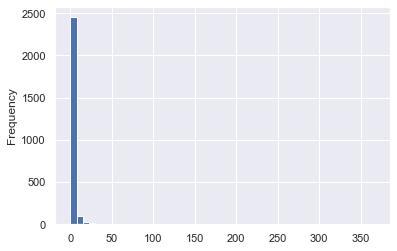

In [14]:
# Create a distribution of frequency to understand the customer frequence level
summary['frequency'].plot(kind='hist', bins=50)
print(summary['frequency'].describe())
print("---------------------------------------")
one_time_buyers = round(sum(summary['frequency'] == 0)/float(len(summary))*(100),2)
print("Percentage of customers purchase the item only once:", one_time_buyers ,"%")

Now, let's fit the BG/NBD model to our summary data.

BG/NBD model is available as **BetaGeoFitter** class in lifetimes package.

In [15]:
# Fitting the BG/NBD model
bgf = lifetimes.BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 2615 subjects, a: 0.39, alpha: 16.78, b: 1.33, r: 0.22>

In [16]:
# Model summary
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.218279,0.008915,0.200805,0.235753
alpha,16.779933,1.179340,14.468426,19.091440
a,0.387987,0.042371,0.304941,0.471034
b,1.334940,0.184841,0.972652,1.697228


上表顯示了從歷史數據中估計的分佈參數值。 該模型會使用它來預測未來的交易和客戶流失率。

因此，假設您想根據歷史數據了解客戶現在是否還活著（或預測客戶流失）。 在Lifetimes 函式庫中可以使用：

**1. model.conditional_probability_alive():** 此函數可以用來計算具有歷史記錄（frequency, recency, T）的客戶當前還活著的概率。 

**2. plot_probabilty_alive_matrix(model):** 這個函數可以協助我們直觀地分析recency, frequency與客戶存活之間的關係。

In [17]:
# Compute the customer alive probability
summary['probability_alive'] = bgf.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary.head(10)

,invoice_cus_id,frequency,recency,T,monetary_value,probability_alive
0,201000002.0,122.0,434.0,438.0,527.270492,9.907499e-01
1,701000001.0,181.0,437.0,438.0,1279.011050,9.968217e-01
2,701000002.0,136.0,387.0,438.0,1092.125000,3.230038e-05
3,701000003.0,81.0,294.0,427.0,480.765432,5.699000e-11
4,701000004.0,9.0,125.0,435.0,853.222222,5.512930e-04
5,701000006.0,4.0,302.0,401.0,165.000000,7.811945e-01
6,701000008.0,0.0,0.0,438.0,0.000000,1.000000e+00
7,701000009.0,4.0,305.0,425.0,972.500000,7.458372e-01
8,701000010.0,367.0,438.0,438.0,13758.144414,9.989449e-01
9,701000011.0,1.0,88.0,438.0,6350.000000,3.652369e-01


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

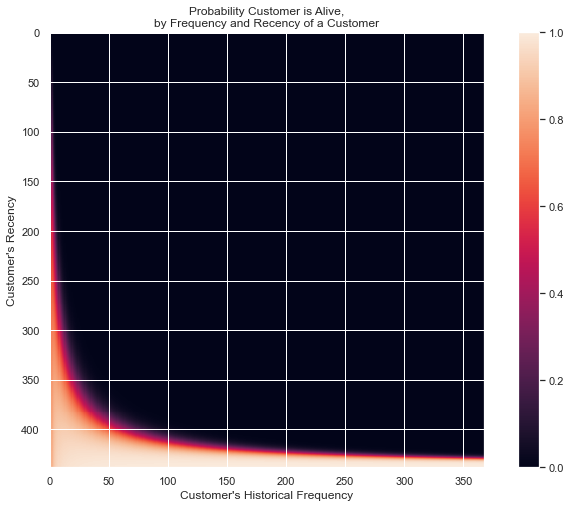

In [18]:
# Visual representation of relationship between recency and frequency
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

稍微解釋一下：

客戶存活機率，是依照客戶的Recency以及Frequency來計算出來的，所以：

* 如果客戶購買了多次（Frequency）並且第一次和最後一次交易之間的時間很長（Recency），那麼他/她存續的可能性就很高。
* 同樣，如果客戶的頻率較低（只有購買一次或兩次）並且第一次和最後一次交易之間的時間很短（Recency），那麼他/她的存活概率就很高。

接下來我們還可以使用這個經過訓練的模型來預測每個客戶未來可能發生的交易。 您可以使用：

`model.conditional_expected_number_of_purchases_up_to_time()`

計算從人群（或整個人群）中隨機選擇的個體到時間 t 的預期重複購買次數 - 假設他們有購買記錄（frequency, recency, T）。

In [19]:
t = 30 # 預測接下來的30天內，各個消費者的預期重複回購次數
summary['pred_num_txn'] = round(bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T']),2)
summary.sort_values(by='pred_num_txn', ascending=False).head(10).reset_index()

,index,invoice_cus_id,frequency,recency,T,monetary_value,probability_alive,pred_num_txn
0,8,701000010.0,367.0,438.0,438.0,13758.144414,0.998945,23.90
1,2392,701003443.0,79.0,98.0,98.0,3692.278481,0.995133,19.67
2,1,701000001.0,181.0,437.0,438.0,1279.011050,0.996822,11.77
3,0,201000002.0,122.0,434.0,438.0,527.270492,0.990750,7.89
4,1328,701001605.0,48.0,342.0,342.0,289.708333,0.992037,3.94
5,1816,701002433.0,34.0,241.0,245.0,437.352941,0.981221,3.77
6,1751,701002326.0,30.0,257.0,258.0,140.466667,0.985921,3.19
7,2531,701003765.0,6.0,33.0,34.0,271.666667,0.935184,3.14
8,335,701000367.0,47.0,413.0,421.0,1095.872340,0.980795,3.13
9,1616,701002107.0,29.0,284.0,289.0,2824.275862,0.979038,2.76


既然我們預測了預期的未來交易，我們現在需要預測每筆交易的未來貨幣價值。

就像我之前提到的，BG/NBD 模型只能預測客戶的未來交易和流失率。 為了增加問題的貨幣方面，我們必須使用 **Gamma-Gamma 模型** 對貨幣價值進行建模。 

Gamma-Gamma 模型的一些關鍵假設是：

1. 客戶給定交易的貨幣價值在其平均交易價值附近隨機變化。
2. 平均交易價值因客戶而異，但對於任何給定客戶不會隨時間而變化。
3. 客戶之間平均交易價值的分佈與交易過程無關。

作為將模型擬合到數據之前的第一步，我們必須檢查模型所做的假設是否適用於這些數據：只有滿足了，我們才繼續進行。

**注意**：我們只考慮重複購買的客戶，即頻率 > 0。因為如果頻率為 0，則意味著他們是一次性客戶並且被認為已經流失。

In [20]:
# Checking the relationship between frequency and monetary_value
return_customers_summary = summary[summary['frequency']>0]
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.308369
monetary_value,0.308369,1.000000


在這個CASE中，交易的頻率和貨幣價值之間沒有關係，我們可以透過相關性驗證其相關姓性並不顯著。

再來，我們利用 Gamma-Gamma 模型進行建模：

In [21]:
# Modeling the monetary value using Gamma-Gamma Model
ggf = lifetimes.GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(return_customers_summary['frequency'],
       return_customers_summary['monetary_value'])

# Summary of the fitted parameters
ggf.summary    

,coef,se(coef),lower 95% bound,upper 95% bound
p,10.770713,0.421400,9.944770,11.596656
q,0.665780,0.023646,0.619433,0.712127
v,10.636420,0.429762,9.794086,11.478754


接下來，我們可以使用該模型預測每筆交易的預期平均利潤和客戶生命週期價值。

**1. model.conditional_expected_average_profit():** 該函數計算一個或多個客戶的每筆交易的期望平均利潤。

**2. model.customer_lifetime_value():** 該函數計算一組一個或多個客戶的平均生命週期價值。 該方法以 BG/NBD 模型和預測範圍作為參數來計算 CLTV。


In [22]:
# Calculating the conditional expected average profit for each customer per transaction
summary = summary[summary['monetary_value'] >0]
summary['exp_avg_sales'] = ggf.conditional_expected_average_profit(summary['frequency'],
                                       summary['monetary_value'])
summary.head()

,invoice_cus_id,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales
0,201000002.0,122.0,434.0,438.0,527.270492,9.907499e-01,7.89,527.491842
1,701000001.0,181.0,437.0,438.0,1279.011050,9.968217e-01,11.77,1279.289134
2,701000002.0,136.0,387.0,438.0,1092.125000,3.230038e-05,0.00,1092.452468
3,701000003.0,81.0,294.0,427.0,480.765432,5.699000e-11,0.00,481.081044
4,701000004.0,9.0,125.0,435.0,853.222222,5.512930e-04,0.00,857.360073


**注意：** 我們使用上述方法所得到的銷售額而不是利潤。我們可以另外將結果乘以我們的利潤率，得出實際利潤值。

In [23]:
# Checking the expected average value and the actual average value in the data to make sure the values are good
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 731.1509233516309
Actual Average Sales: 713.8926372998563


現在，讓我們直接使用Lifetime 函式庫中的函數來計算客戶生命週期價值。

有幾件事情要注意：

**1. time:** customer_lifetime_value()函數中的這個參數以月為單位，t=1表示一個月，以此類推。

**2. freq:** 此參數是您將指定數據所在的時間單位的位置。如果您的數據是每日級別，那麼“D”，每月“M”等等。

**3. discount_rate:** 這個參數是基於DCF（discounted cash flow）的概念，你將未來的貨幣價值通過一個貼現率貼現得到該現金流的現值。 在文件中，給出的預設值是每月 0.01（每年 ~12.7%）。

In [24]:
# Predicting Customer Lifetime Value for the next 30 days
summary['predicted_clv'] =      ggf.customer_lifetime_value(bgf,
                                                               summary['frequency'],
                                                               summary['recency'],
                                                               summary['T'],
                                                               summary['monetary_value'],
                                                               time=1,              # lifetime in months
                                                               freq='D',            # frequency in which the data is present(T)      
                                                               discount_rate=0.01)  # discount rate
summary.head()

,invoice_cus_id,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv
0,201000002.0,122.0,434.0,438.0,527.270492,9.907499e-01,7.89,527.491842,4.120102e+03
1,701000001.0,181.0,437.0,438.0,1279.011050,9.968217e-01,11.77,1279.289134,1.490641e+04
2,701000002.0,136.0,387.0,438.0,1092.125000,3.230038e-05,0.00,1092.452468,3.100526e-01
3,701000003.0,81.0,294.0,427.0,480.765432,5.699000e-11,0.00,481.081044,1.471555e-07
4,701000004.0,9.0,125.0,435.0,853.222222,5.512930e-04,0.00,857.360073,2.830461e-01


您還可以根據未來交易的預測數量 (pred_num_txn) 和每筆交易的預期平均銷售額 (exp_avg_sales) 手動計算 CLTV。

In [25]:
summary['manual_predicted_clv'] = summary['pred_num_txn'] * summary['exp_avg_sales']
summary.head()

,invoice_cus_id,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv
0,201000002.0,122.0,434.0,438.0,527.270492,9.907499e-01,7.89,527.491842,4.120102e+03,4161.910633
1,701000001.0,181.0,437.0,438.0,1279.011050,9.968217e-01,11.77,1279.289134,1.490641e+04,15057.233110
2,701000002.0,136.0,387.0,438.0,1092.125000,3.230038e-05,0.00,1092.452468,3.100526e-01,0.000000
3,701000003.0,81.0,294.0,427.0,480.765432,5.699000e-11,0.00,481.081044,1.471555e-07,0.000000
4,701000004.0,9.0,125.0,435.0,853.222222,5.512930e-04,0.00,857.360073,2.830461e-01,0.000000


兩個 CLV 值非常接近，並且在接下來的 30 天內似乎是合理的。

這裡需要注意的一點是，我們為 CLTV 計算的兩個值都是銷售價值，而不是實際利潤。

## Summary

我們預測了每個客戶未來 30 天的 CLTV。

行銷及業務團隊現在可以透過這些信息來定位客戶並尋求合適的方式來增加他們的銷售額。

希望你喜歡這篇文章。

## 延伸閱讀：透過 kmeans 進行消費族群分群

在我們取得消費者個交易紀錄後，我們可以嘗試透過機器學習的方式，來將這些消費這進行適當的分群 (Cluster)

先載入相關的 Python 函式庫

In [26]:
from sklearn.cluster import KMeans

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

我們需要建立一個副程式來檢查數據的偏移程度

In [27]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

由於我們希望透過消費者交易的Recency/Frenquency/Monetary來進行分群，我們檢查一下相關的數據：

recency's: Skew: 0.40947604860633036, : SkewtestResult(statistic=5.512357451345715, pvalue=3.54058924329199e-08)
frequency's: Skew: 16.63523236612824, : SkewtestResult(statistic=42.62794152572261, pvalue=0.0)
monetary_value's: Skew: 5.81288775759373, : SkewtestResult(statistic=30.559282782393712, pvalue=4.256870081427745e-205)


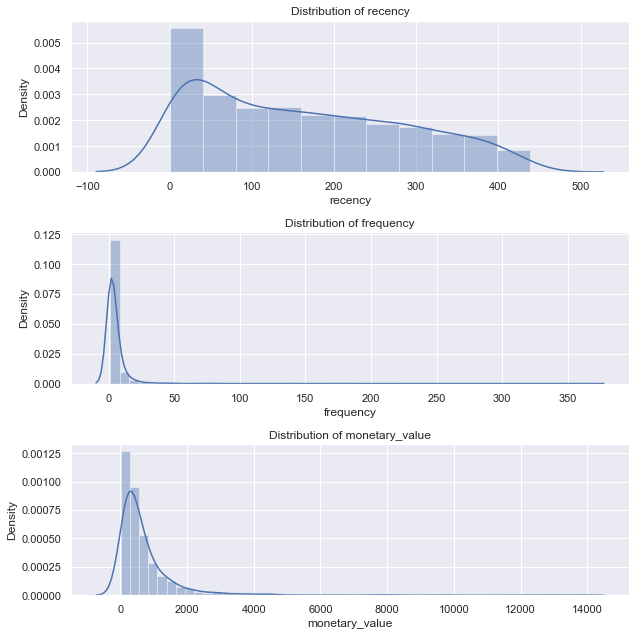

In [28]:
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(summary,'recency')
plt.subplot(3, 1, 2)
check_skew(summary,'frequency')
plt.subplot(3, 1, 3)
check_skew(summary,'monetary_value')
plt.tight_layout()

我們注意到，相關數據的偏移度過大（具有長尾現象），我們需要將這些數據重新整理，進行特徵標準化(normalization)工作

我們首先將相關數據轉換為對數形式：

In [29]:
clv_rfm = summary[['invoice_cus_id','recency','frequency','T','monetary_value']]
clv_rfm['invoice_cus_id'].astype("string")

0        201000002.0
1        701000001.0
2        701000002.0
3        701000003.0
4        701000004.0
            ...     
2560     701003812.0
2562     701003819.0
2563     701003820.0
2585     701003866.0
2613    7010015607.0
Name: invoice_cus_id, Length: 1158, dtype: string

recency's: Skew: -1.3410639462558533, : SkewtestResult(statistic=-14.558048034387495, pvalue=5.1919215569780646e-48)
frequency's: Skew: 0.9384463240043922, : SkewtestResult(statistic=11.248149137017123, pvalue=2.3650279001736935e-29)
monetary_value's: Skew: 0.023739117952762616, : SkewtestResult(statistic=0.33185198477126177, pvalue=0.7400010282457292)


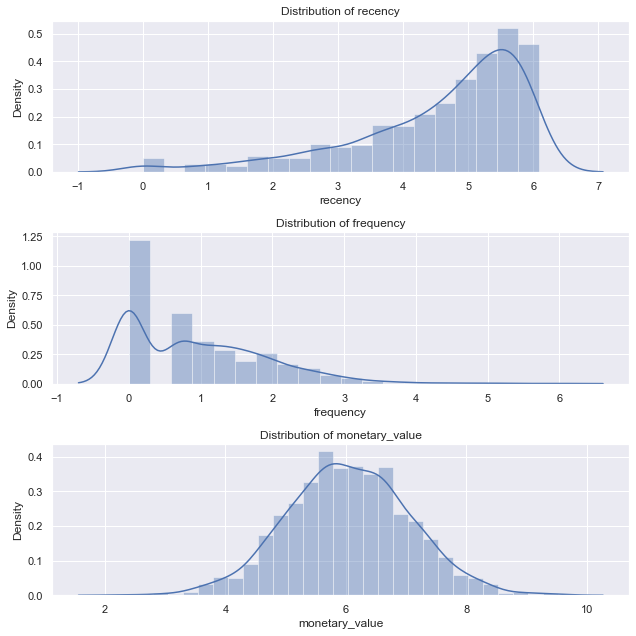

In [30]:
#Removing Skewness
clv_log = np.log(clv_rfm)
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(clv_log,'recency')
plt.subplot(3, 1, 2)
check_skew(clv_log,'frequency')
plt.subplot(3, 1, 3)
check_skew(clv_log,'monetary_value')
plt.tight_layout()

可以看到當數據以對數形式呈現時，其偏移度相對改善許多，接下來，我們繼續處理特徵標準化(normalization)工作

In [31]:
scaler = StandardScaler()
RFM_Table_scaled_array = scaler.fit_transform(clv_log)

In [32]:
RFM_Table_scaled  = pd.DataFrame(RFM_Table_scaled_array ,columns=clv_log.columns,index=clv_log.index,)
RFM_Table_scaled.head()

,invoice_cus_id,recency,frequency,T,monetary_value
0,-16.240378,1.124740,4.005419,0.830115,0.220959
1,-0.011846,1.129844,4.416920,0.830115,1.092030
2,-0.011846,1.039817,4.118742,0.830115,0.936752
3,-0.011846,0.836180,3.578171,0.780481,0.130194
4,-0.011846,0.202501,1.286118,0.816703,0.694087


#### k-means的運作

K-means運作概念步驟:

1. 我們先設定好要分成多少(k)群。
2. 然後在feature space(x軸身高和y軸體重組出來的2維空間，假設資料是d維，則會組出d維空間)隨機給k個群心。
3. 每個資料都會所有k個群心算歐式距離(歐基李德距離Euclidean distance，其實就是直線距離公式，從小學到大的那個距離公式，這邊距離當然也可以換成別種距離公式，但基本上都還是以歐式距離為主)。
4. 將每筆資料分類判給距離最近的那個群心。
5. 每個群心內都會有被分類過來的資料，用這些資料更新一次新的群心。
6. 一直重複3–5，直到所有群心不在有太大的變動(收斂)，結束

K-means clustering 就是希望可以最小化群內的資料和群心的誤差平方和越小越好。我們根據這個概念，嘗試透過Elbow Method，推論處最適合的K值

*Elbow Method是在 K-means 算法中將模型與 K 值的範圍擬合來選擇最佳數最流行的方法之一。它需要在 SSE（平方誤差和）與簇數之間繪製一條線圖，並找到代表“Elbow"的點（在該點之後，SSE 或慣性開始以線性方式減小）。*

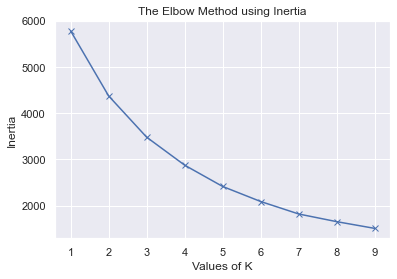

In [33]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_
    

plt.plot(K,inertias,'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

我們在Elbow Method中所得到的數值（圖表） ，並沒有明倩的Elobow點，我們需要做更多嘗試

我們再建立一個副程式，將不同K值的特徵圖表描繪出來：

In [34]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)
    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

    return df_new

我們嘗試以K值為 4/5/6 分別進行圖表繪製：

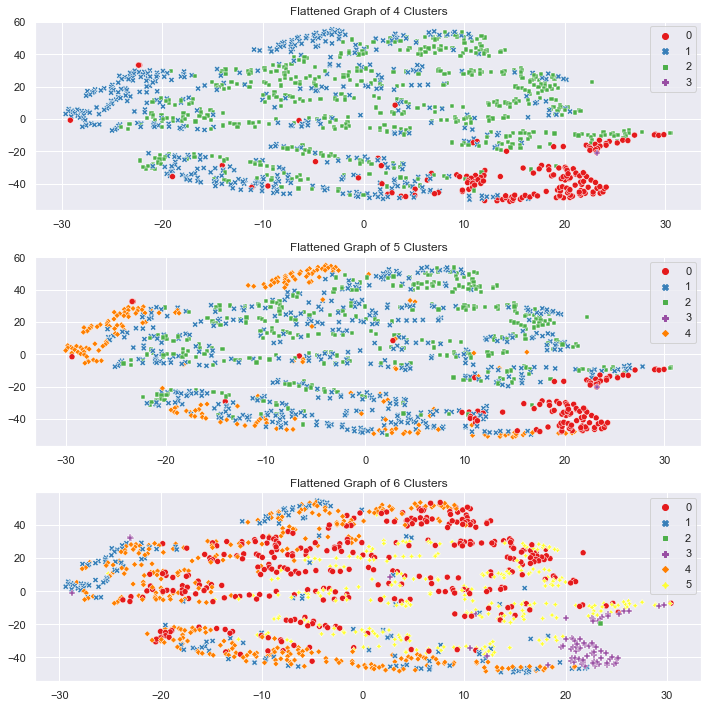

In [36]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, clv_rfm)
plt.subplot(3, 1, 2)
df_rfm_k5 = kmeans(RFM_Table_scaled, 5, clv_rfm)
plt.subplot(3, 1, 3)
df_rfm_k6 = kmeans(RFM_Table_scaled, 6, clv_rfm)
plt.tight_layout()

我們再撰寫一個副程式，繪製分群的Snake Plot：

In [38]:
def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Cluster'] = df_rfm_kmeans['Cluster']
    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['invoice_cus_id', 'Cluster'],
                        value_vars=['recency', 'frequency', 'monetary_value'], 
                        var_name='Metric', 
                        value_name='Value')
    plt.xlabel('Metric')
    plt.ylabel('Value')
    sns.pointplot(data=df_melt, x='Metric', y='Value', hue='Cluster')
    
    return

以K值為 4/5/6 分別進行圖表繪製：

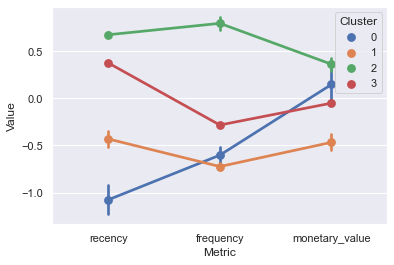

In [39]:
# k=4
snake_plot(RFM_Table_scaled_array,df_rfm_k4,clv_log)

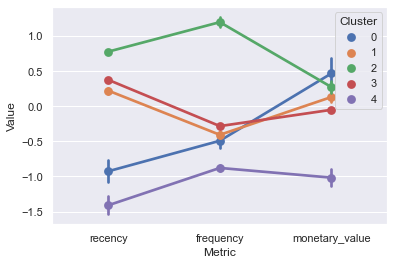

In [40]:
# k=5
snake_plot(RFM_Table_scaled_array,df_rfm_k5,clv_log)

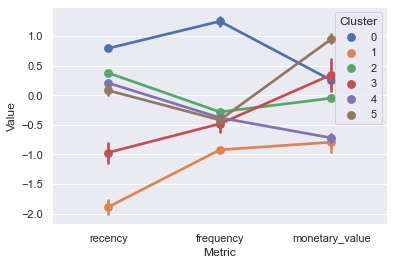

In [41]:
# k=6
snake_plot(RFM_Table_scaled_array,df_rfm_k6,clv_log)

**根據上面圖表中的特徵差異，選擇合適的Cluster數量**

目前，應以**5**為合適值

In [42]:
df_cluster_selected = df_rfm_k5.copy()
df_cluster_selected.head()
df_cluster_selected.groupby('Cluster').describe()

invoice_cus_id                                            \
                 count          mean           std           min   
Cluster                                                            
0                104.0  7.010032e+08  6.576772e+02  7.010007e+08   
1                486.0  7.010016e+08  9.175926e+02  7.010000e+08   
2                360.0  6.996122e+08  2.635237e+07  2.010000e+08   
3                  1.0  7.010016e+09           NaN  7.010016e+09   
4                207.0  7.010015e+08  9.677252e+02  7.010000e+08   

                                                                recency  \
                  25%           50%           75%           max   count   
Cluster                                                                   
0        7.010032e+08  7.010034e+08  7.010036e+08  7.010039e+08   104.0   
1        7.010008e+08  7.010016e+08  7.010024e+08  7.010032e+08   486.0   
2        7.010003e+08  7.010010e+08  7.010016e+08  7.010034e+08   360.0   
3        7.010016e+09  7.010016e+09  7.010016e+09  7.010016e+09     1.0   
4        7.010008e+08  7.010014e+08  7.010024e+08  7.010034e+08   207.0   

                     ...      T        monetary_value               \
               mean  ...    75%    max          count         mean   
Cluster              ...                                             
0         42.509615  ...  131.5  307.0          104.0  1303.274279   
1        157.273663  ...  404.0  438.0          486.0   708.833813   
2        285.916667  ...  420.0  438.0          360.0   829.070090   
3        158.000000  ...  344.0  344.0            1.0   400.000000   
4         27.946860  ...  404.5  438.0          207.0   230.863205   

                                                                    \
                 std         min         25%         50%       75%   
Cluster                                                              
0        1750.402065   35.000000  288.333333  687.791667  1383.250   
1         768.709031   45.000000  265.416667  450.000000   843.875   
2        1160.899275   51.333333  298.553571  532.666667   973.815   
3                NaN  400.000000  400.000000  400.000000   400.000   
4         281.807964   10.000000   87.500000  150.000000   251.500   

                       
                  max  
Cluster                
0         9615.000000  
1         6350.000000  
2        13758.144414  
3          400.000000  
4         2100.000000  

[5 rows x 40 columns]

在分群的數據描述中，我們發現有一個分群 (Cluster=3)，其資料筆數僅有 1 筆

In [43]:
df_cluster_selected[df_cluster_selected['Cluster']==3]

,invoice_cus_id,recency,frequency,T,monetary_value,Cluster
2613,7.010016e+09,158.0,2.0,344.0,400.0,3


在這裡，我們先不對這筆資料進行排除或清理，僅先將分群後的數據與之前計算CLTV的數據進行整併：

In [46]:
clv_merge = summary.copy()
clv_merge = clv_merge.rename_axis('cus_id').reset_index()

In [47]:
df_cluster_selected_merge = df_cluster_selected.copy()
df_cluster_selected_merge = df_cluster_selected.rename_axis('cus_id').reset_index()
df_cluster_selected_merge.drop(columns=["frequency", "recency","monetary_value","T"],inplace=True)

*注意：因為進行分群計算的基礎數據已經經過特徵標準化處理，所以我們不需要將這些資料整併回 CLTV 數據中*

In [48]:
clv_final = pd.merge(clv_merge,df_cluster_selected_merge,on='cus_id')
clv_final.head(10)

,cus_id,invoice_cus_id_x,frequency,recency,T,monetary_value,probability_alive,pred_num_txn,exp_avg_sales,predicted_clv,manual_predicted_clv,invoice_cus_id_y,Cluster
0,0,201000002.0,122.0,434.0,438.0,527.270492,9.907499e-01,7.89,527.491842,4.120102e+03,4161.910633,201000002.0,2
1,1,701000001.0,181.0,437.0,438.0,1279.011050,9.968217e-01,11.77,1279.289134,1.490641e+04,15057.233110,701000001.0,2
2,2,701000002.0,136.0,387.0,438.0,1092.125000,3.230038e-05,0.00,1092.452468,3.100526e-01,0.000000,701000002.0,2
3,3,701000003.0,81.0,294.0,427.0,480.765432,5.699000e-11,0.00,481.081044,1.471555e-07,0.000000,701000003.0,2
4,4,701000004.0,9.0,125.0,435.0,853.222222,5.512930e-04,0.00,857.360073,2.830461e-01,0.000000,701000004.0,2
5,5,701000006.0,4.0,302.0,401.0,165.000000,7.811945e-01,0.23,168.969907,3.909935e+01,38.863079,701000006.0,2
6,7,701000009.0,4.0,305.0,425.0,972.500000,7.458372e-01,0.21,982.783147,2.054615e+02,206.384461,701000009.0,2
7,8,701000010.0,367.0,438.0,438.0,13758.144414,9.989449e-01,23.90,13759.336769,3.255674e+05,328848.148788,701000010.0,2
8,9,701000011.0,1.0,88.0,438.0,6350.000000,3.652369e-01,0.03,6564.330322,1.888321e+02,196.929910,701000011.0,1
9,10,701000012.0,9.0,341.0,438.0,275.555556,7.249446e-01,0.44,277.694823,1.197687e+02,122.185722,701000012.0,2
